0) **Imports**

In [1]:
import os, sys
from timeit import default_timer as timer
import dolfin as df # Fenics : dolfin + ufl + FIAT + ...
import numpy as np
import matplotlib.pyplot as plt
import fetricks as ft

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


1) **Consititutive behaviour Definition**

shuffling


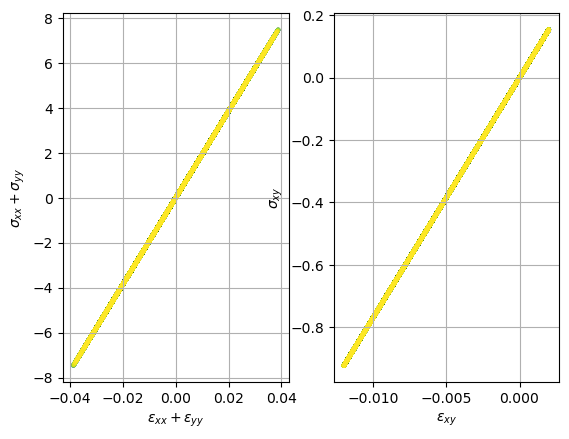

In [2]:
# fetricks is a set of utilitary functions to facilitate our lives
from fetricks.mechanics.elasticity_conversions import youngPoisson2lame
from ddfenics.dd.ddmaterial import DDMaterial 

database_file = 'database_generated.txt'

Nd = 100000 # number of points
noise = 0.0
eps_range = np.array([[-0.03,0.03], [-0.009, 0.009], [-0.012, 0.002]]).T
E = 100.0
nu = 0.3

lamb, mu = youngPoisson2lame(nu, E) 
Cmat = np.array( [[lamb + 2*mu, lamb, 0], [lamb, lamb + 2*mu, 0], [0, 0, 2*mu]] )

np.random.seed(1)
DD = np.zeros((Nd,2,3))

for i in range(Nd):
    DD[i,0,:] = eps_range[0,:] + np.random.rand(3)*(eps_range[1,:] - eps_range[0,:])
    DD[i,1,:] = Cmat@DD[i,0,:] + noise*np.random.randn(3)
    
np.savetxt(database_file, DD.reshape((-1,6)), header = '1.0 \n%d 2 3 3'%Nd, comments = '', fmt='%.8e', )

ddmat = DDMaterial(database_file)  # replaces sigma_law = lambda u : ...

ddmat.plotDB()

2) **Mesh** (Unchanged) 

In [3]:
Nx =  50 # x10
Ny =  10 # x10
Lx = 2.0
Ly = 0.5
mesh = df.RectangleMesh(df.Point(0.0,0.0) , df.Point(Lx,Ly), Nx, Ny, 'left/right');
# df.plot(mesh);

3) **Mesh regions** (Unchanged)

In [4]:
leftBnd = df.CompiledSubDomain('near(x[0], 0.0) && on_boundary')
rightBnd = df.CompiledSubDomain('near(x[0], Lx) && on_boundary', Lx=Lx)

clampedBndFlag = 1
loadBndFlag = 2
boundary_markers = df.MeshFunction("size_t", mesh, dim=1, value=0)
leftBnd.mark(boundary_markers, clampedBndFlag)
rightBnd.mark(boundary_markers, loadBndFlag)

dx = df.Measure('dx', domain=mesh)
ds = df.Measure('ds', domain=mesh, subdomain_data=boundary_markers)

4) **Spaces** (Unchanged)

In [5]:
from ddfenics.dd.ddspace import DDSpace

Uh = df.VectorFunctionSpace(mesh, "Lagrange", 1) # Unchanged
bcL = df.DirichletBC(Uh, df.Constant((0.0, 0.0)), boundary_markers, clampedBndFlag) # Unchanged

# Space for stresses and strains
# Sh0 = df.VectorFunctionSpace(mesh, 'DG', degree = 0 , dim = 3) 
Sh0 = DDSpace(Uh, 3, 'DG') 

spaces = [Uh, Sh0]

5) **Variational Formulation**: <br>

- Strong format: 
$$
\begin{cases}
div \sigma = 0  \text{in} \, \Omega \\
u = 0 \quad \text{on} \, \Gamma_1 \\
\varepsilon = \nabla^s u \quad \text{in} \, \Omega \\
\sigma  n  = t \quad \text{on} \, \Gamma_2 \\
\end{cases}
$$ 
- DD equilibrium subproblem: Given $(\varepsilon^*, \sigma^*) \in Z_h$, solve for $(u,\eta) \in U_h$  
$$
\begin{cases}
(\mathbb{C} \nabla^s u , \nabla^s v ) = (\mathbb{C} \varepsilon^* , \nabla^s v ) \quad \forall v \in U_h, \\
(\mathbb{C} \nabla^s \eta , \nabla^s \xi ) = \Pi_{ext}(\xi) - (\sigma^* , \nabla^s \xi ) \quad \forall \xi \in U_h \\
\end{cases}
$$
- Updates:
$$
\begin{cases}
\varepsilon = \nabla^s u \\
\sigma = \sigma^* + \mathbb{C} \nabla^s \eta
\end{cases}
$$
- DD ''bilinear'' form : $(\bullet , \nabla^s v)$ or sometimes  $(\mathbb{C} \nabla^s \bullet, \nabla^s v)$ 

In [6]:
# Unchanged
uh = df.TrialFunction(Uh)
vh = df.TestFunction(Uh)

ty = -0.1
traction = df.Constant((0.0, ty))
b = df.inner(traction,vh)*ds(loadBndFlag)

# Changed
from ddfenics.dd.ddmetric import DDMetric
from ddfenics.dd.ddbilinear import DDBilinear

dddist = DDMetric(ddmat = ddmat, V = Sh0, dx = dx)
print("Error C estimation (SVD):", np.linalg.norm(Cmat - dddist.C)/np.linalg.norm(Cmat))
assert np.allclose(Cmat, dddist.C,atol = 1.e-7)

a = DDBilinear(dddist, ft.symgrad_mandel, uh, vh, dx)

Error C estimation (SVD): 1.0323692080864496e-11


6) **Statement and Solving the problem** <br> 
- DDProblem : States DD equilibrium subproblem and updates.
- DDSolver : Implements the alternate minimization using SKlearn NearestNeighbors('ball_tree', ...) searchs for the projection onto data.
- Stopping criteria: $\|d_k - d_{k-1}\|/energy$

In [7]:
from ddfenics.dd.ddfunction import DDFunction
from ddfenics.dd.ddproblem_generic import DDProblemGeneric as DDProblem # Generic implementation
from ddfenics.dd.ddsolver import DDSolver

# replaces df.LinearVariationalProblem(a, b, uh, bcs = [bcL])
problem = DDProblem(a, spaces, ft.symgrad_mandel, b, [bcL], metric = dddist) 

sol = problem.get_sol()

start = timer()

#replaces df.LinearVariationalSolver(problem)
solver = DDSolver(problem, ddmat, opInit = 'random', seed = 1)
tol_ddcm = 1e-7
solver.solve(tol = tol_ddcm, maxit = 100);

end = timer()

uh = sol["u"]
normL2 = df.assemble(df.inner(uh,uh)*dx)
norm_energy = df.assemble(df.inner(sol['state_mech'][0],sol['state_mech'][1])*dx)

print("Time spent: ", end - start)
print("Norm L2: ", normL2)
print("Norm energy: ", norm_energy)

assert np.allclose(normL2, 0.0033714383487846397)
assert np.allclose(norm_energy, 0.005907312062796587)

TypeError: __init__() got multiple values for argument 'metric'

7) **Plotting**

a) *Minimisation*

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


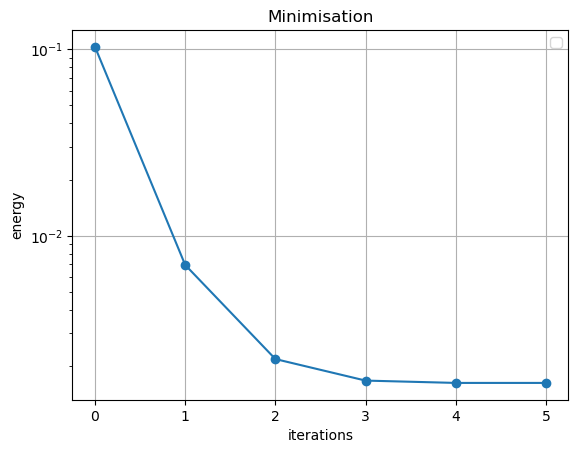

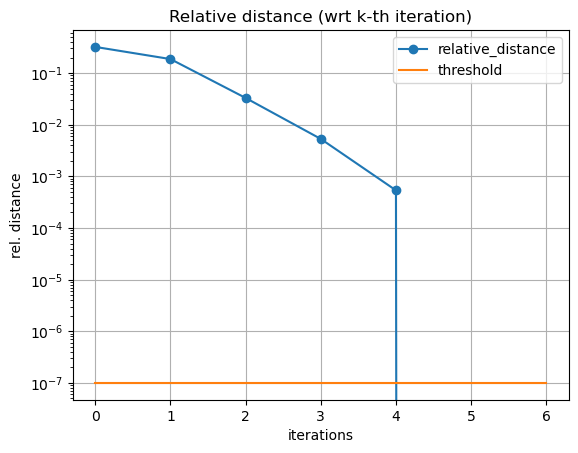

In [ ]:
hist = solver.hist

fig = plt.figure(2)
plt.title('Minimisation')
plt.plot(hist['relative_energy'], 'o-')
plt.xlabel('iterations')
plt.ylabel('energy')
plt.legend(loc = 'best')
plt.yscale('log')
plt.grid()

fig = plt.figure(3)
plt.title('Relative distance (wrt k-th iteration)')
plt.plot(hist['relative_distance'], 'o-', label = "relative_distance")
plt.plot([0,len(hist['relative_energy'])],[tol_ddcm,tol_ddcm], label = "threshold")
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('rel. distance')
plt.legend(loc = 'best')
plt.grid()